![tutorialpromo](images/tutorial_banner.PNG)


# Tutorial 1 - Weather Data: Accesing it, understanding it, visualizing it!


This notebook explores a standard type of weather data, the typical meteorological year (TMY), and how to summarize it with Python and [Pandas](https://pandas.pydata.org/).

![Overview](images/tutorial_1_overview.PNG)

## Steps:
- [Weather data in PV performance models](#Weather-Data-&-PV)
- Looking at a sample weather data file
- Where to get weather data from? 
- Weather data to API

## PV Concepts:
- TMY
- GHI, DNI, DHI
- DryBulb, Wspd
- Irradiance vs. Insolation

## Python Concepts:
- Exploring a Pandas dataframe (`df`): `len()`, `df.head()`, `df.keys()`
- [pvlib input-output tools](https://pvlib-python.readthedocs.io/en/stable/api.html#io-tools)
- Ploting a Pandas dataframe (`df`): `df.plot()`
- Aggregating data in a dataframe (`df`): `df.resample(freq).sum()`
- Getting NREL irradiance data from the web based API using pvlib

## Weather Data & PV 

Weather and irradiance data are used as input to PV performance models.  


![SRRL](images/tutorial_1_SRRL.PNG)



These data are directly measured, derived from measured data, or simulated using a stochastic model.






## Typical Meteorological Year

TMY datasets are intended to represent the weather for a typical year at a given location. 

TMY datasets provide hourly **solar irradiance**, **air temperature**, **wind speed**, and other weather measurements for a hypothetical year that represents more or less a "median year" for solar resource.  


![TMY3 screenshot](images/tutorial_1_tmy3_example.PNG)

TMY datasets are created by selecting individual months out of an extended period of weather measurememts (say, 20 years of data) to construct a single year's worth of data. There are several methods for selecting which months to include, but the general idea is to calculate monthly summary statistics and take the month that lies in the middle of the distribution.  For example, no two Januaries will be exactly the same, so summing the total solar irradiance for each January will give a [normal distribution](https://en.wikipedia.org/wiki/Normal_distribution), and the month that falls closest to the [median](https://en.wikipedia.org/wiki/Median) is chosen as the representative month. The same process is followed for February, March, and so on, and all twelve representative months are stitched together into a year-long dataset.  

The oldest TMYs were calculated using data from the nearest weather station (airports and such). Today, it's common to use TMYs calculated using simulated weather data from satellite imagery because of the improved spatial resolution.

To get a better feel for TMY data, we'll first explore an example TMY dataset that is bundled with pvlib.

## First Step: Import Libraries

In Python, some functions are builtin like `print()` but others must be imported before they can be used. For this notebook we're going to import three packages:
* [pvlib](https://pvlib-python.readthedocs.io/en/stable/) - library for simulating performance of photovoltaic energy systems. 
* [pandas](https://pandas.pydata.org/) - analysis tool for timeseries and tabular data
* [matplotlib](https://matplotlib.org/) - data visualization for Python

Some Python modules are part of the [standard library](https://docs.python.org/3/library/index.html), but are not imported with builtins. We'll use the `pathlib` module which is useful for accessing files and folders.

In [1]:
import pvlib
import pandas as pd  # for data wrangling
import matplotlib.pyplot as plt  # for visualization
import pathlib  # for finding the example dataset

Query which version you are using of pvlib:

In [2]:
print(pvlib.__version__)

0.8.1


## Reading a TMY dataset with pvlib

First, we'll read the TMY dataset with [`pvlib.iotools.read_tmy3()`](https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.iotools.read_tmy3.html) which returns a [Pandas DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) of the timeseries weather data and a second output with a Python dictionary of the TMY metadata like longitude, latitude, elevation, etc.

We will use the Python [`pathlib`](https://docs.python.org/3/library/pathlib.html) to get the path to the `'data'` directory which comes with the `pvlib` package. Then we can use the slash operator, `/` to make the full path to the TMY file.

In [3]:
help(pvlib.iotools.read_tmy3)

Help on function read_tmy3 in module pvlib.iotools.tmy:

read_tmy3(filename, coerce_year=None, recolumn=True)
    Read a TMY3 file in to a pandas dataframe.
    
    Note that values contained in the metadata dictionary are unchanged
    from the TMY3 file (i.e. units are retained). In the case of any
    discrepancies between this documentation and the TMY3 User's Manual
    [1]_, the TMY3 User's Manual takes precedence.
    
    The TMY3 files were updated in Jan. 2015. This function requires the
    use of the updated files.
    
    Parameters
    ----------
    filename : str
        A relative file path or absolute file path.
    
    coerce_year : None or int, default None
        If supplied, the year of the index will be set to `coerce_year`, except
        for the last index value which will be set to the *next* year so that
        the index increases monotonically.
    
    recolumn : bool, default True
        If ``True``, apply standard names to TMY3 columns. Typically th

In [4]:
DATA_DIR = pathlib.Path(pvlib.__file__).parent / 'data'
df_tmy, meta_dict = pvlib.iotools.read_tmy3(DATA_DIR / '723170TYA.CSV', coerce_year=1990)
meta_dict  # display the dictionary of metadata

{'USAF': 723170,
 'Name': '"GREENSBORO PIEDMONT TRIAD INT"',
 'State': 'NC',
 'TZ': -5.0,
 'latitude': 36.1,
 'longitude': -79.95,
 'altitude': 273.0}

Let's display the first 4 lines of the dataframe

In [5]:
df_tmy.head(4)

,Date (MM/DD/YYYY),Time (HH:MM),ETR,ETRN,GHI,GHISource,GHIUncertainty,DNI,DNISource,DNIUncertainty,...,Alb,AlbSource,AlbUncertainty,Lprecipdepth,Lprecipquantity,LprecipSource,LprecipUncertainty,PresWth,PresWthSource,PresWthUncertainty
1990-01-01 01:00:00-05:00,01/01/1988,01:00,0,0,0,1,0,0,1,0,...,0.0,?,0,0,1,D,9,0,C,8
1990-01-01 02:00:00-05:00,01/01/1988,02:00,0,0,0,1,0,0,1,0,...,0.0,?,0,0,1,D,9,0,C,8
1990-01-01 03:00:00-05:00,01/01/1988,03:00,0,0,0,1,0,0,1,0,...,0.0,?,0,0,1,D,9,0,C,8
1990-01-01 04:00:00-05:00,01/01/1988,04:00,0,0,0,1,0,0,1,0,...,0.0,?,0,0,1,D,9,0,C,8


This dataset follows the standard format of handling timeseries data with pandas -- one row per timestamp, one column per measurement type.  Because TMY files represent one year of data (no leap years), that means they'll have 8760 rows.  The number of columns can vary depending on the source of the data.

In [6]:
print("Number of rows:", len(df_tmy))
print("Number of columns:", len(df_tmy.columns))

Number of rows: 8760
Number of columns: 71


You can access single rows by pointing to its number location (iloc) or by using the index name it has. In this case, that is a dateTime


In [7]:
df_tmy.iloc[0];

In [8]:
df_tmy.loc['1990-01-01 01:00:00-05:00'];

You can also print all the column names in the dataframe

In [9]:
df_tmy.keys()

Index(['Date (MM/DD/YYYY)', 'Time (HH:MM)', 'ETR', 'ETRN', 'GHI', 'GHISource',
       'GHIUncertainty', 'DNI', 'DNISource', 'DNIUncertainty', 'DHI',
       'DHISource', 'DHIUncertainty', 'GHillum', 'GHillumSource',
       'GHillumUncertainty', 'DNillum', 'DNillumSource', 'DNillumUncertainty',
       'DHillum', 'DHillumSource', 'DHillumUncertainty', 'Zenithlum',
       'ZenithlumSource', 'ZenithlumUncertainty', 'TotCld', 'TotCldSource',
       'TotCldUncertainty', 'OpqCld', 'OpqCldSource', 'OpqCldUncertainty',
       'DryBulb', 'DryBulbSource', 'DryBulbUncertainty', 'DewPoint',
       'DewPointSource', 'DewPointUncertainty', 'RHum', 'RHumSource',
       'RHumUncertainty', 'Pressure', 'PressureSource', 'PressureUncertainty',
       'Wdir', 'WdirSource', 'WdirUncertainty', 'Wspd', 'WspdSource',
       'WspdUncertainty', 'Hvis', 'HvisSource', 'HvisUncertainty', 'CeilHgt',
       'CeilHgtSource', 'CeilHgtUncertainty', 'Pwat', 'PwatSource',
       'PwatUncertainty', 'AOD', 'AODSource', 'AODU

There are 71 columns, which is quite a lot!  For now, let's focus just on the ones that are most important for PV modeling -- the irradiance, temperature, and wind speed columns, and extract them into a new DataFrame.

## Irradiance 

Irradiance is an instantaneous measurement of solar power over some area.  For practical purposes of measurement and interpretation, irradiance is expressed and separated into different components.

![overview irradiance](images/tutorial_1_DNIDHIGHI.PNG)

The units of irradiance are watts per square meter.  

## Wind

Wind speed is measured with an anemometer.  The most common type is a the cup-type anemometer, shown on the right side of the picture below.  The number of rotations per time interval is used to calculate the wind speed.  The vane on the left is used to measure the direction of the wind.  Wind direction is reported as the direction from which the wind is blowing.

<img src="https://pvpmc.sandia.gov/wp-content/uploads/2012/04/anemometer.jpg"></img>

## Air temperature 

Also known as dry-bulb temperature, is the temperature of the ambient air when the measurement device is shielded from radiation and moisture. The most common method of air temperature measurement uses a resistive temperature device (RTD) or thermocouple within a radiation shield. The shield blocks sunlight from reaching the sensor (avoiding radiative heating), yet allows natural air flow around the sensor. More accurate temperature measurement devices utilize a shield which forces air across the sensor.

Air temperature is typically measured on the Celsius scale.

Air temperature plays a large role in PV system performance as PV modules and inverters are cooled convectively by the surrounding air.

<img src="https://pvpmc.sandia.gov/wp-content/uploads/2012/04/AmbTemp.jpg" width="400" height="400"> </img>

## Downselect columns 

There are a lot more weather data in that file that you can access. To investigate all the column headers, we used `.keys()` above. Always read the [Instruction Manual](https://www.nrel.gov/docs/fy08osti/43156.pdf) for the weather files to get more details on how the data is aggregated, units, etc.

At this point we are interested in <b> GHI, DHI, DNI, DryBulb </b> and <b> Wind Speed </b>. For this NREL TMY3 dataset the units of irradiance are W/m&sup2;, dry bulb temperature is in &deg;C, and wind speed is m/s.

In [10]:
# GHI, DHI, DNI are irradiance measurements
# DryBulb is the "dry-bulb" (ambient) temperature
# Wspd is wind speed
df = df_tmy[['GHI', 'DHI', 'DNI', 'DryBulb', 'Wspd']]
# show the first 15 rows:
df.head(15)

,GHI,DHI,DNI,DryBulb,Wspd
1990-01-01 01:00:00-05:00,0,0,0,10.0,6.2
1990-01-01 02:00:00-05:00,0,0,0,10.0,5.2
1990-01-01 03:00:00-05:00,0,0,0,10.0,5.7
1990-01-01 04:00:00-05:00,0,0,0,10.0,5.7
1990-01-01 05:00:00-05:00,0,0,0,10.0,5.2
1990-01-01 06:00:00-05:00,0,0,0,10.0,4.1
1990-01-01 07:00:00-05:00,0,0,0,10.0,4.1
1990-01-01 08:00:00-05:00,9,9,1,10.0,5.2
1990-01-01 09:00:00-05:00,46,46,3,10.0,5.2
1990-01-01 10:00:00-05:00,79,78,4,10.6,5.2


## Plotting time series data with pandas and matplotlib

Let's make some plots to get a better idea of what TMY data gives us.

### Irradiance

First, the three irradiance fields:

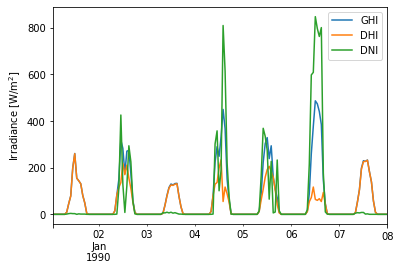

In [11]:
first_week = df.head(24*7)  # Plotting 7 days, each one has 24 hours or entries
first_week[['GHI', 'DHI', 'DNI']].plot()
plt.ylabel('Irradiance [W/m$^2$]');

Let's control the parameters a bit more

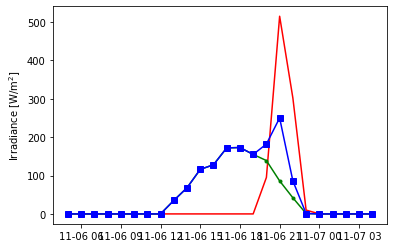

In [12]:
birthday = df.loc['1990-11-06':'1990-11-06']
plt.plot(birthday['DNI'], color='r') 
plt.plot(birthday['DHI'], color='g', marker='.') 
plt.plot(birthday['GHI'], color='b', marker='s') 
plt.ylabel('Irradiance [W/m$^2$]');

#### Exercise

How does the Irradiance look like in YOUR birthday?

Hint: the next cell is 'Markdown', you need to switch it to 'Code' for it to run

birthday = df.loc[] # Type your birthday here using the 1990 year, i.e. '1990-11-06':'1990-11-06'
plt.plot(birthday['DNI'], color='g') 
plt.plot(birthday['DHI'], color='b', marker='.') 
plt.plot(birthday['GHI'], color='r', marker='s') 
plt.ylabel('Irradiance [W/m$^2$]');

GHI, DHI, and DNI are the three "basic" ways of measuring irradiance, although each of them is measured in units of power per area (watts per square meter):

- GHI: Global Horizontal Irradiance; the total sunlight intensity falling on a horizontal plane
- DHI: Diffuse Horizontal Irradiance; the subset of sunlight falling on a horizontal plane that isn't coming directly from the sun (e.g., the light that makes the sky blue)
- DNI: Direct Normal Irradiance; the subset of sunlight coming directly from the sun

![Overview](images/t1_GHI.PNG)



![Overview](images/t1_DHI.PNG)



![Overview](images/t1_DNI.PNG)


Later tutorials will show how these three values are used in PV modeling.  For now, let's just get a qualitative understanding of the differences between them: looking at the above plot, there is a pattern where when DNI is high, DHI is low.  The sun puts out a (roughly) constant amount of energy, which means photons either make it through the atmosphere without scattering and are counted as direct irradiance, or they tend to get scattered and become part of the diffuse irradiance, but not both.  Looking at DNI makes it easy to pick out which hours are cloud and which are sunny -- most days in January are rather overcast with low irradiance, but the sun does occasionally break through.

In addition to daily variation, there is also seasonal variation in irradiance.  Let's compare a winter week with a summer week, using pandas to select out a summertime subset.  Notice the increased intensity in summer -- GHI peaks around 900 W/m^2, whereas in winter the maximum was more like 500 W/m^2.

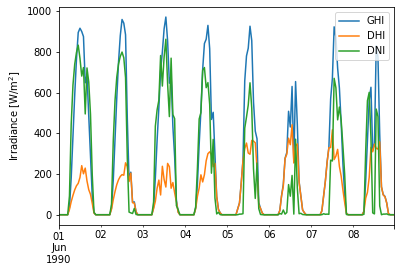

In [13]:
summer_week = df.loc['1990-06-01':'1990-06-08']
summer_week[['GHI', 'DHI', 'DNI']].plot()
plt.ylabel('Irradiance [W/m$^2$]');

### Temperature

Next up is temperature:

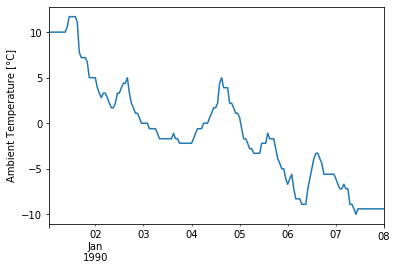

In [14]:
first_week['DryBulb'].plot()
plt.ylabel('Ambient Temperature [°C]');

### Wind speed

And finally, wind speed:

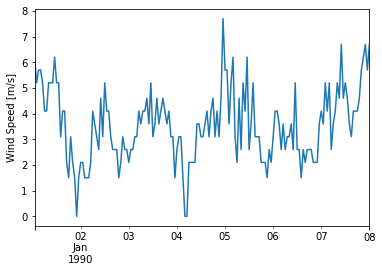

In [15]:
first_week['Wspd'].plot()
plt.ylabel('Wind Speed [m/s]');

## Aggregating hourly data to monthly summaries

Pandas makes it easy to roll-up timeseries data into summary values.  For example, we can calculate total monthly GHI as a quick way to visualize the seasonality of solar resource:

In [16]:
# summing hourly irradiance (W/m^2) gives insolation (W h/m^2)
monthly_ghi = df['GHI'].resample('M').sum()
monthly_ghi.head(4)

1990-01-31 00:00:00-05:00     74848
1990-02-28 00:00:00-05:00     85751
1990-03-31 00:00:00-05:00    131766
1990-04-30 00:00:00-05:00    162302
Freq: M, Name: GHI, dtype: int64

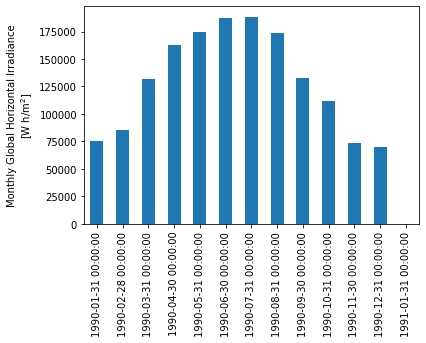

In [17]:
monthly_ghi = monthly_ghi.tz_localize(None)  # don't need timezone for monthly data
monthly_ghi.plot.bar()
plt.ylabel('Monthly Global Horizontal Irradiance\n[W h/m$^2$]');

We can also take monthly averages instead of monthly sums:

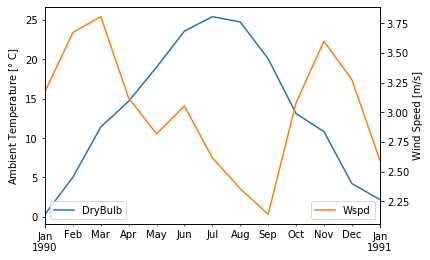

In [18]:
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()  # add a second y-axis
monthly_average_temp_wind = df[['DryBulb', 'Wspd']].resample('M').mean()
monthly_average_temp_wind['DryBulb'].plot(ax=ax1, c='tab:blue')
monthly_average_temp_wind['Wspd'].plot(ax=ax2, c='tab:orange')
ax1.set_ylabel(r'Ambient Temperature [$\degree$ C]')
ax2.set_ylabel(r'Wind Speed [m/s]')
ax1.legend(loc='lower left')
ax2.legend(loc='lower right');

### Exercise

Plot the Average DNI per Day

In [19]:
try:
    daily_average_DNI = df[['']].resample('').mean()  # Add the column name, and resample by day. Month is 'M', day is..
    daily_average_DNI.plot()
except:
    print("You haven't finished this exercise correctly, try again!")

You haven't finished this exercise correctly, try again!


## Where to get Solar Irradiance Data?

There are many different sources of solar irradiance data. For your projects, these are some of the most common:

- [TMY3/TMY2](https://nsrdb.nrel.gov/data-sets/archives.html) - like the data we loaded earlier on this example. This database of TMY3 `.csv` files and TMY2 files have been archived by NREL.

- [NSRDB](https://maps.nrel.gov/nsrdb-viewer/) - National Solar Radiation Database. You can access data through the website for many locations accross the world, or you can use their [web API](https://developer.nrel.gov/docs/solar/nsrdb/) to download data programmatically. An "API" is an ["application programming interface"](https://en.wikipedia.org/wiki/API), and a "web API" is a programming interface that allows you to write code to interact with web services like the NSRDB.

- [EPW](https://www.energy.gov/eere/buildings/downloads/energyplus-0) - Energy Plus Weather data is available for many locations accross the world. It's in its own format file ('EPW') so you can't open it easily in a spreadsheet program like Excel, but you can use [`pvlib.iotools.read_epw()`](https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.iotools.read_epw.html) to get it into a dataframe and use it.

- [PVGIS](https://ec.europa.eu/jrc/en/pvgis) - Free global weather data provided by the European Union and derived from many govermental agencies including the NSRDB. PVGIS also provides a web API. You can get PVGIS TMY data using [`pvlib.iotools.get_pvgis_tmy()`](https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.iotools.get_pvgis_tmy.html).

- Perhaps another useful link: https://sam.nrel.gov/weather-data.html


![NSRDB Example](images/tutorial_1_NSRDB_example.PNG)


## Fetching TMYs from the NSRDB

The example TMY dataset used here is from an airport in North Carolina, but what if we wanted to model a PV system somewhere else? The NSRDB, one of many sources of weather data intended for PV modeling, is free and easy to access using pvlib. As an example, we'll fetch a TMY dataset for Albuquerque, New Mexico at coordinates [(35.0844, -106.6504)](https://www.google.com/maps/@35.0844,-106.6504,9z). We use [`pvlib.iotools.get_psm3()`](https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.iotools.get_psm3.html) which returns a Python dictionary of metadata and a Pandas dataframe of the timeseries weather data.

In [20]:
metadata, df_abq = pvlib.iotools.get_psm3(
    latitude=35.0844, longitude=-106.6504,
    api_key='DEMO_KEY',  # OK for this demo, but better to get your own key
    email='silvanaa@gmail.com',
    names='tmy')
metadata

{'Source': 'NSRDB',
 'Location ID': '94139',
 'City': '-',
 'State': '-',
 'Country': '-',
 'Latitude': 35.09,
 'Longitude': -106.66,
 'Time Zone': -7,
 'Elevation': 1496,
 'Local Time Zone': -7,
 'Dew Point Units': 'c',
 'DHI Units': 'w/m2',
 'DNI Units': 'w/m2',
 'GHI Units': 'w/m2',
 'Temperature Units': 'c',
 'Pressure Units': 'mbar',
 'Wind Direction Units': 'Degrees',
 'Wind Speed': 'm/s',
 'Surface Albedo Units': 'N/A',
 'Version': '3.1.1'}

TMY datasets from the PSM3 service of the NSRDB are timestamped using the real year that the measurements came from. The [`pvlib.iotools.read_tmy3()`](https://pvlib-python.readthedocs.io/en/stable/generated/pvlib.iotools.read_tmy3.html) function had a `coerce_year` argument to force everything to align to a single dummy year, but `pvlib.iotools.get_psm3()` doesn't have that feature. For convenience let's standardize the data to 1990 and then compare monthly GHI to the North Carolina location:

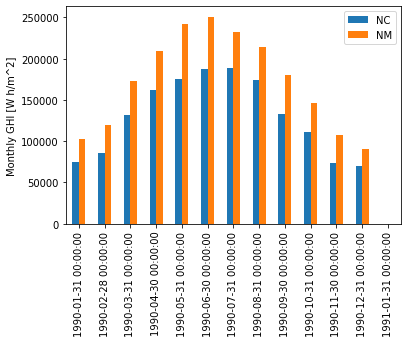

In [21]:
df_abq['Year'] = 1990
df_abq.index = pd.to_datetime(df_abq[['Year', 'Month', 'Day', 'Hour']])

ghi_comparison = pd.DataFrame({
    'NC': monthly_ghi,  # using the monthly values from earlier
    'NM': df_abq['GHI'].resample('M').sum(),
})

ghi_comparison.plot.bar()
plt.ylabel('Monthly GHI [W h/m^2]');

It's not too surprising to see that our New Mexico location is significantly sunnier than the one in North Carolina.

[![Creative Commons License](https://i.creativecommons.org/l/by/4.0/88x31.png)](http://creativecommons.org/licenses/by/4.0/)

This work is licensed under a [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0/).